# E5BDA - MNIST Classifiers
#### Janus Bo Andersen (JA67494 / AU191419)
***

This report/notebook is for the fulfilment of exam requirements in the course E5BDA (Big Data) Fall 2020. The report and code was made by the stated author.

## Assignment: 
- Train three different classifiers on Mnist dataset (keras.datasets.mnist) and present the accuracy of the classification. 
- There must be at least one classical model, and one Neural Net model among the three models.
- Argue for which classifier works best and present ideas to improve the classifier.

## Solution summary:
- Three classifiers have been trained and evaluated on MNIST data.
- The **best** performing is a **convolutional neural network** with an **accuracy of 0.9887**.
- The implemented models are:

| # | Model                              | Comments                                   | Accuracy |
|:- | :-                                 | :-                                         | -:       |
| 1 | Convolutional Neural Network (CNN) | Single 2D conv. layer with 16 filters, 5x5 kernels, <br/> 3x3 feature max pooling, <br/> 2 dense hidden layers with  300 and 100 nodes, all ReLU, <br/> softmax output, <br/> SGD optimizer and cross-entropy loss fct., <br/> 20 epochs   | .9887 |
| 2 | Multilayer Perceptron (MLP-ANN)        | 2 dense hidden layers, 784 and 784 nodes (ReLU), <br/> softmax output, <br/> SGD optimizer, cross-entropy lossfct., <br/> 20 epochs | .9789 |
| 3 | K-Nearest Neighbours (KNN), SVD dimensionality reduction | 3 nearest neighbours, <br/> Dimensionality reduction with SVD using 50 largest singular values | .9754 |

***
## Notes on improvement ideas:

__For both neural nets__
- Optimize hyperparameters further
    - Train for more epochs (or, stop early if no improvements)
        - BUT: For both models, there were signs that further training could cause over-fitting.
    - Change learning rate
        - The standard was used.
    - Change optimizer to something else than Stochastic Gradient Descent
    - Try different activation functions than ReLU
    - Fiddle with the batch size
    - Change the dropout rates (re-normalization and reduce overfitting)
        - $0.15$ was used, which might be on the low side.
        - Could be analyzed if any improvements at $0.2$, $0.3$, etc.
- Optimize structure
    - Change the number of neurons per layer, BUT
        - CNN: Two layers of $784$ neurons each gave same result as $300$ + $100$, so the number of neurons is _not_ the limiting factor in this classifier (no marginal effect). However, there were signs that the model was becoming over-fitted for the in-sample data.
        - MLP: Going from layer neuron counts of $300$ and $100$ to $2$ layers with $784$, did have a marginally positive effect ($97.63\%$ -> $97.89\%$ on the out-of-sample test), but like the CNN, there were signs that further training would have over-fitted the model to the in-sample data.
    - Add more layers (again, be careful of over-fitting)
        - Due to the above, any new layers should be convolutional / pooling for the CNN.
        - Unlikely that more dense layers will improve the MLP, already "enough" neurons available.
- Perform dimensionality reduction on input data (to remove noise)


__CNN__
- Further convolutional layers
    - However, having two Conv2D layers with $16$ filters each and $3 \times 3$ and $5 \times 5$ kernels did not improve the model
- Different pooling structure could be attempted

__MLP-ANN__
- Mainly the hyperparameters mentioned above

__KNN__
- Usually $K=3$ is a sweet spot, but for different slicing of the data, try to change $K$ to compare with more neighbours, and see if accuracy improves.
- Use higher dimensionality than 50% to include more variance, while still doing noise suppression.
- Using PCA instead of SVD had little effect, as they essentially do the same thing. I prefer SVD as one does not need to do normalization, the data is still recognizable.

__General Analysis__
- More insight into causes of errors in the classification (confusion matrix)
- Ensuring that training sets and test sets are evenly distributed (both representative)
- Many more models could be interesting to try out.

***
## Conclusion

For this supervised learning/classification task, two different types of Neural Networks and a classical model, KNN, were implemented. 

The highest accuracy was achieved by the CNN with $98.87 \%$. It has about $339,000$ trainable parameters. It is also the most complex structure and is the slowest to train. 

The other Neural Network, an MLP Network (or just "regular network"), performed fairly well too with $97.89 \%$, while being somewhat faster to train. Due to the higher number of neurons in the two hidden layers, it has about $1,240,000$ trainable parameters. 

Besides a 2D convolution layer and the attached feature pooling layer, the two networks have similar structure in the fully connected layers. Adding more neurons to the dense layers in the CNN has no marginal effect: So the very significant $0.98\%$-points difference in accuracy is purely due to the convolutional layer (same random seeding used).

The last model, a 3-neighbours KNN, performed surprisingly well too with $97.54 \%$, only marginally less than the second neural net. Further, it is instantaneous to train due to lazy-learning (in purest form, all lazy and no fitting, in Scikit a graph can be fitted). Its main downside is _very_ slow classification for high-dimensionality data like images (computing the $L_2$ norm $N$ times is slow / computationally complex).

For that reason, data dimensionality was reduced. The original dimension is $784$ ($28 \times 28$). By decomposing the $N \times 784$ matrix with the Singular Value Decomposition (SVD) and choosing only the $50$ largest singular values, $82.44 \%$ of the dataset variance is retained, noise is reduced and _significantly_ faster prediction and scoring is achieved.

Finally, a number of notes and ideas for improvement have been listed.

According to the original webpage for the MNIST data (see [Yann LeCun](http://yann.lecun.com/exdb/mnist/)), the best performing CNN has an accuracy of $99.73 \%$. According to the competition at Kaggle (see [Kaggle Benchmark](https://paperswithcode.com/sota/image-classification-on-mnist)), the best is at $99.84 \%$. Either way, there is significant room for improvement. On the other hand, it is impressive that a free, and open-source Python library enables you to get so "close" to best-in-class.

***

# The MNIST dataset: Load and split into training, cross-validation and hold-out testing
This is a dataset of with $60,000$ training samples and $10,000$ test samples. The data is $28 \times 28$ grayscale images of the digits $0-9$ ($X$) and corresponding class labels ($y$). 
Source: [Keras MNIST](https://keras.io/api/datasets/mnist/).
- Input: $28 \times 28$ grayscale images (uint8)
- Output: Sparse labels $0, \ldots, 9$. -> Exclusive in $1$ of $10$ classes -> Multiclass classification

In [1]:
from keras.datasets import mnist
(x_train_all, y_train_all), (x_test, y_test) = mnist.load_data();

#### Pre-process the data
- Split the training set:
    - Reduce training set to $57,000$ items, in order to make
    - Cross-validation set with $3,000$ items. This is used for hyperparameter tuning.
- Normalize x-data to floating point in range $[0; 1]$


In [2]:
N = x_train_all.shape[0]                      # Total items
N_test = x_test.shape[0]                      # Hold-out test items
i_m, i_n =  x_train_all.shape[1:]             # Image (m x n) matrix (1D tensor)

N_validation = 3000                           # Use 5% of training set for validation in each epoch
N_train = N - N_validation                    # Remaining for training

x_train = x_train_all[N_validation:] / 255.   # Normalization and casting to float
y_train = y_train_all[N_validation:]

x_validation = x_train_all[:N_validation] / 255.
y_validation = y_train_all[:N_validation]

x_test = x_test / 255.

***

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD

***
# 1. Convolutional Neural Network (CNN)

In [4]:
keras.backend.clear_session()
np.random.seed(1)
tf.random.set_seed(1)

In [5]:
# Reshape to tensors, 1 deep for greyscale
X = x_train.reshape((N_train, i_m, i_n, 1))
Y = y_train
Xv = x_validation.reshape((N_validation, i_m, i_n, 1))
Yv = y_validation
Xt = x_test.reshape((N_test, i_m, i_n, 1))
Yt = y_test

In [6]:
# CNN model structure
n_filters = 16        # 16 filters
cnn_kernel = 5        # 5x5 convolution kernel, seems good to find the kinds of features that are in MNIST
batch_size = 1
pooling_kernel = 3    # 3x3 feature pooling
dropout_rate = 0.15

model_cnn = keras.models.Sequential([
    keras.Input(shape = (i_m, i_m, 1)),             # Pre-processing input layer
    keras.layers.Conv2D(
        n_filters, 
        kernel_size = cnn_kernel, 
        activation = "relu", 
        input_shape = [batch_size, i_m, i_n, 1]
    ),
    keras.layers.MaxPooling2D(pooling_kernel),      # (n x n) maximum feature pooling
    keras.layers.Flatten(),                         # Flatten feature tensor for onwards layer
    keras.layers.Dense(300, activation="relu"),     # Fully-connected hidden layer
    keras.layers.Dropout(dropout_rate),             # To avoid overfitting
    keras.layers.Dense(100, activation="relu"),     # Fully-connected hidden layer
    keras.layers.Dropout(dropout_rate),             # To avoid overfitting
    keras.layers.Dense(10, activation="softmax")    # Output layer for exclusive classes
])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               307500    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [7]:
# Compile model with cross-entropy loss fct., using stochastic gradient descent opt. (def. learning rate)
model_cnn.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "sgd",
    metrics = ["accuracy"]
)

In [8]:
# Train
history = model_cnn.fit(
    X, 
    Y, 
    epochs = 20,
    validation_data=(Xv, Yv),
    verbose = 0
)

Scoring using the validation data shows the result after tuning hyper parameters. __Be aware__ that validation data could have been used for optimizing hyper parameters, and therefore is likely to be subject to overfitting!

In [9]:
score_cnn_val =  model_cnn.evaluate(Xv, Yv)

94/94 [==============================] - 0s 4ms/step - loss: 0.0455 - accuracy: 0.9860


The **real accuracy score** for the model is **$98.87 \%$** by using the hold-out test data, which was _not_ used for hyperparameter tuning:

In [10]:
score_cnn_test = model_cnn.evaluate(Xt, Yt)

313/313 [==============================] - 1s 4ms/step - loss: 0.0308 - accuracy: 0.9887


Check for model overfitting by seeing that validation accuracy and epoch accuracy track nicely, and that the final hold-out test accuracy is close to the line of convergence.

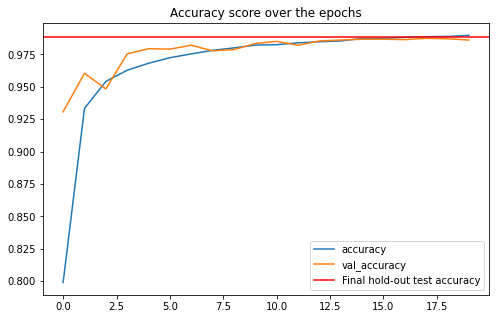

In [11]:
h = {k: v for k, v in history.history.items() if k in ['accuracy', 'val_accuracy']}
pd.DataFrame(h).plot(figsize=(8, 5))
plt.axhline(score_cnn_test[1], color='r', label='Final hold-out test accuracy')
plt.legend()
plt.title('Accuracy score over the epochs')
plt.show()

***
# 2. Multi-Layer Perceptron Network, regular ANN (MLP-ANN)
Feed-forward type with fully-connected (dense) layers

In [12]:
keras.backend.clear_session()
np.random.seed(1)
tf.random.set_seed(1)

In [13]:
model_mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (i_m, i_m)), # # pre-processing input layerFlatten tensor for onwards layer
    keras.layers.Dense(784, activation="relu"),     # fully-connected hidden layer
    keras.layers.Dropout(0.15),                     # To avoid overfitting
    keras.layers.Dense(784, activation="relu"),     # fully-connected hidden layer
    keras.layers.Dropout(0.15),                     # To avoid overfitting
    keras.layers.Dense(10, activation="softmax")    # output layer for exclusive classes
])

model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
______________________________________________

In [14]:
# Compile model with cross-entropy loss fct., using stochastic gradient descent opt. (def. learning rate)
model_mlp.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "sgd",
    metrics = ["accuracy"]
)

In [15]:
# Train
history_mlp = model_mlp.fit(
    x_train, 
    y_train, 
    epochs = 20,
    validation_data=(x_validation, y_validation),
    verbose = 0
)

Scoring using the validation data shows the validation data on the final model. Be aware that validation could have been used for optimizing hyper parameters, and can be subject to overfitting!

In [16]:
score_mlp_val = model_mlp.evaluate(x_validation, y_validation)

94/94 [==============================] - 0s 3ms/step - loss: 0.0805 - accuracy: 0.9767


The **real accuracy score** for the model is **$97.89 \%$** by using the hold-out test data, which was _not_ used for hyperparameter tuning:

In [17]:
score_mlp_test = model_mlp.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0702 - accuracy: 0.9789


Check for model overfitting by seeing that validation accuracy and epoch accuracy track nicely, and that the final hold-out test accuracy is close to the line of convergence.

The chart shows that in-sample accuracy is overperforming the cross-validation set and the final test set. This is a clear indication that the classifier is becoming over-fitted!

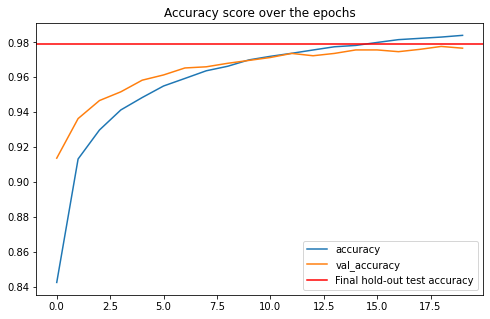

In [18]:
h = {k: v for k, v in history_mlp.history.items() if k in ['accuracy', 'val_accuracy']}
pd.DataFrame(h).plot(figsize=(8, 5))
plt.axhline(score_mlp_test[1], color='r', label='Final hold-out test accuracy')
plt.legend()
plt.title('Accuracy score over the epochs')
plt.show()

# 3. K-Nearest Neighbours

In [19]:
# Reshape data to N x 784 matrices
# Only use the same training data as for the neural nets, to be fair.
X = x_train.reshape(N_train, -1)
y = y_train
Xt = x_test.reshape(N_test, -1)
yt = y_test

Reduce the data dimensionality by the Singular Value Decomposition. Use 50 largest singular values.

In [20]:
svd = TruncatedSVD(
    n_components=50,
    n_iter=10,
    random_state=1
)
svd.fit(X)

TruncatedSVD(n_components=50, n_iter=10, random_state=1)

The 50 largest singular values explain $82.44 \%$ of the variance. This method likely removes a lot of noise.

In [21]:
print(f"Explained var.: {round(sum(svd.explained_variance_ratio_)*100, 2)}%")

Explained var.: 82.44%


In [22]:
Xsvd = svd.transform(X)

Set up a $K=3$-neighbours model

In [23]:
model_knn_svd = KNeighborsClassifier(
    n_neighbors=3,     # look at 3 nearest
    n_jobs=-1          # this can be slow high dimensionality, so use all cpu cores
)

Fit the model, takes no time (really just lazy training)

In [24]:
model_knn_svd.fit(Xsvd, y)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

Score the model by transforming the hold-out testing set by the same SVD matrix decomposition. This still takes a few seconds to do, as $10,000$ vectors with $50$ parameters have the $L_2$ norm calculated.

In [25]:
model_knn_svd.score(svd.transform(Xt), yt)

0.9754

The out-of-sample accuracy is $97.54 \%$, which is very nice for such a simple model.